In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
%matplotlib inline

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
# To download the data and .py scripts
!wget https://www.dropbox.com/sh/wqyi4lrwdjuw5m9/AACbWYfg7dXCxiZfv1xCHwtEa?dl=0

In [0]:
# To unzip it
!unzip AACbWYfg7dXCxiZfv1xCHwtEa?dl=0

In [5]:
import sys
sys.path.append('..')
import cigmodel
from cigmodel import basemodel
from lib import *

I tried to use the original model, but it turned out that it does not fit on the GPU (it couldn't do forward pass even with one example), that's why I change the model. So i had to make the model smaller by reducing the number of channels in each layer significantly, and also changed the maxpool layer with params 2 by 2 with stride 2 to 4 by 4 with stride 4. Instead of up-sampling I used transpoded convolution and batch normalization (refused to use dropout)

I use quite simple weighted loss: I multiply the loss on cigarette by 5 

First I trained a model on data without augmentation and saved the best model (with the biggest dice value on the vallidation data)

In [6]:
net = basemodel.Basenet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
optimizer = torch.optim.Adam(net.parameters())

In [8]:
train_set = cigmodel.dataloader.CigDataset('../data/cig_butts/train')
val_set = cigmodel.dataloader.CigDataset('../data/cig_butts/val')

train_gen = DataLoader(train_set, batch_size=24, shuffle=True)
val_gen = DataLoader(val_set, batch_size=16, shuffle=True)

Epoch number 1
Train loss = 115480.34375	Train dice = 0.0001515076224876372
Val loss = 90271.4921875	Val dice = 0.0012602803960612083
Epoch number 2
Train loss = 73279.8828125	Train dice = 0.00017483596958611073
Val loss = 58643.4765625	Val dice = 0.0
Epoch number 3
Train loss = 48767.4296875	Train dice = 0.0002035415521888116
Val loss = 38082.83984375	Val dice = 0.0
Epoch number 4
Train loss = 33213.34375	Train dice = 0.0
Val loss = 26589.298828125	Val dice = 0.0
Epoch number 5
Train loss = 23195.162109375	Train dice = 0.0030290760337539305
Val loss = 19096.544921875	Val dice = 0.01963555715472814
Epoch number 6
Train loss = 16471.796875	Train dice = 0.36450065270828585
Val loss = 13950.5478515625	Val dice = 0.6732515642050362
Epoch number 7
Train loss = 12194.0078125	Train dice = 0.6144870286546352
Val loss = 10921.5166015625	Val dice = 0.634567926520213
Epoch number 8
Train loss = 9474.955078125	Train dice = 0.6501206523207518
Val loss = 7778.82080078125	Val dice = 0.734204574648945

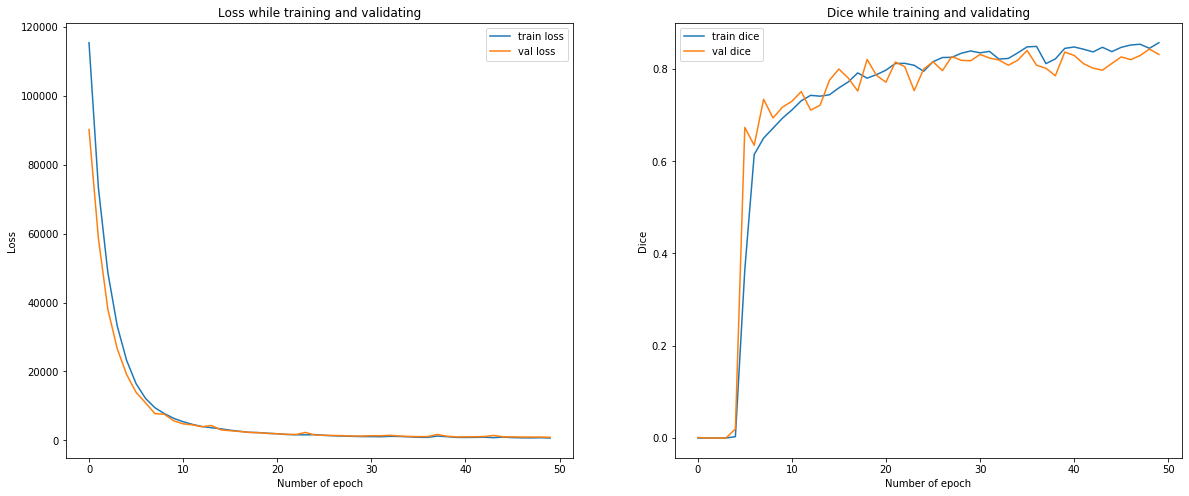

In [7]:
max_epoch = 50
threshold = 0.5
path = 'cigmodel/base_best_model_demo.pt'
a, b, c, d = basemodel.train_net(net, max_epoch, basemodel.dice_metric, threshold, train_gen, val_gen,
                                 optimizer, path, device, True)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = cigmodel.basemodel.Basenet().to(device)
optimizer = torch.optim.Adam(model.parameters())

path = '../cigmodel/base_best_model_demo.pt'
checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss_value = checkpoint['values']['train_loss']
val_loss_value = checkpoint['values']['val_loss']
train_dice = checkpoint['values']['train_dice']
val_dice = checkpoint['values']['val_dice']

In [12]:
print(f"Dice validation data is {val_dice}")

Dice validation data is 0.8431550844995908


![](images/values_base_best_model.png)

Then I looked at how the model works on test data and it was't goof enough.
There were some problems with several examples of cigarettes on one picture.
Then I decided to augment the data. I merged the pictures so that on one there were from 2 to 5 cigarette butts, moreover, cigarettes are about the same size and the more their size, the less number of them in the picture

I continued to train the model on old and new data.
Then I again took the saved model and trained it only on the new data.

In [13]:
# Model trained on old and aug_data
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = cigmodel.basemodel.Basenet().to(device)
optimizer = torch.optim.Adam(model.parameters())

path = '../cigmodel/base_best_model_demo_augm.pt'
checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss_value = checkpoint['values']['train_loss']
val_loss_value = checkpoint['values']['val_loss']
train_dice = checkpoint['values']['train_dice']
val_dice = checkpoint['values']['val_dice']

In [14]:
print(f"Dice validation data is {val_dice}")

Dice validation data is 0.8552316032983677


![](images/values_augm.png)

In [0]:
# Saved model, trained only on the aug_data
train_set = cigmodel.dataloader.CigDataset('data/cig_butts/train/augment', True, True)
val_set = cigmodel.dataloader.CigDataset('data/cig_butts/val')

train_gen = DataLoader(train_set, batch_size=24, shuffle=True)
val_gen = DataLoader(val_set, batch_size=16, shuffle=True)

Epoch number 1
Train loss = 4081.32080078125	Train dice = 0.7900403789861633
Val loss = 1583.002685546875	Val dice = 0.8278993071658076
Epoch number 2
Train loss = 2861.326171875	Train dice = 0.8198497872923267
Val loss = 1602.6553955078125	Val dice = 0.8247080008193367
Epoch number 3
Train loss = 2579.561279296875	Train dice = 0.8270303714559807
Val loss = 1054.792724609375	Val dice = 0.8469871683556509
Epoch number 4
Train loss = 2335.57080078125	Train dice = 0.8337759961111569
Val loss = 1131.75244140625	Val dice = 0.8238003798102018
Epoch number 5
Train loss = 2239.7666015625	Train dice = 0.8357333472164176
Val loss = 899.6483764648438	Val dice = 0.8373242364775878
Epoch number 6
Train loss = 2166.29638671875	Train dice = 0.8380452533882305
Val loss = 1027.076416015625	Val dice = 0.8439305836213713
Epoch number 7
Train loss = 2040.5528564453125	Train dice = 0.8416019602499384
Val loss = 1157.947265625	Val dice = 0.8407799645709542
Epoch number 8
Train loss = 2067.69189453125	Train 

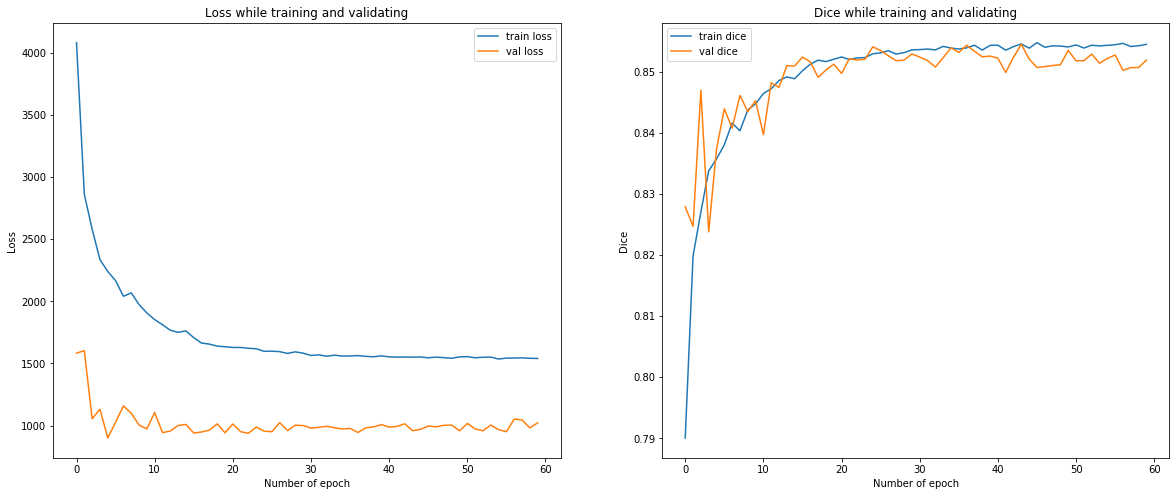

In [7]:
max_epoch = 60
threshold = 0.5
path = 'cigmodel/base_best_model_demo_augm_only_more.pt'
a, b, c, d = basemodel.train_net(model, max_epoch, basemodel.dice_metric, threshold, train_gen, val_gen,
                                 optimizer, path, device, True, True)

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = cigmodel.basemodel.Basenet().to(device)
optimizer = torch.optim.Adam(model.parameters())

path = '../cigmodel/base_best_model_demo_augm_only_more.pt'
checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss_value = checkpoint['values']['train_loss']
val_loss_value = checkpoint['values']['val_loss']
train_dice = checkpoint['values']['train_dice']
val_dice = checkpoint['values']['val_dice']

In [16]:
print(f"Dice validation data is {val_dice}")

Dice validation data is 0.8545100962951564


![values_augm_only_more.png](attachment:im/values_augm_only_more.png)

As the result, a model that only trained on augmented data performed better on test data.
Unfortunately, I did not have time to see how the model will work if it is given more augmented data

In [0]:
# To save results
import pandas as pd

val_masks = basemodel.eval_net(model, basemodel.dice_metric, 0.5, 'data/cig_butts/val', device)
test_masks = basemodel.eval_net(model, basemodel.dice_metric, 0.5, 'data/cig_butts/real_test', device)

In [0]:
rle_val_masks = [encode_rle(mask) for mask in val_masks]
rle_test_masks = [encode_rle(mask) for mask in test_masks]

In [0]:
df = pd.DataFrame({'img_id': np.arange(0, len(rle_val_masks)),
                   'rle_mask': rle_val_masks})
df.to_csv('pred_valid_template.csv',sep='\t', index=False)

In [0]:
from glob import glob
paths_to_imgs = sorted(glob("data/cig_butts/real_test/images/*"))
html = get_html(paths_to_imgs, test_masks, path_to_save="results/example")

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
new_model = cigmodel.basemodel.Basenet().to(device)
optimizer = torch.optim.Adam(model.parameters())

path = 'cigmodel/.pt'
checkpoint = torch.load(path)
new_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

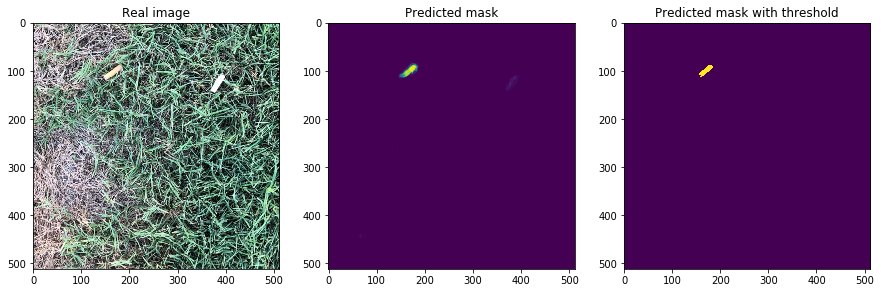

In [62]:
basemodel.draw_sample(new_model, device, "data/cig_butts/real_test", threshold=0.6, rand=1, test=True)